In [ ]:
%cd '/content/drive/MyDrive/3semester/8160/hw5/'

/content/drive/MyDrive/3semester/8160/hw5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [110]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from utils.model import *
from dataset.data import *

In [ ]:
# import os
# print (len(os.listdir('../Pytorch Introduction/data/traffic_signs_class/00029')))

In [ ]:
## transform data
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': labels}

In [ ]:
class traffic_sign(Dataset):
    def __init__(self, root_dir ):

        # initialize dataset variables here
        # self.root = root_dir
        self.root = Path(root_dir)
        self.df = pd.DataFrame(columns = ['image_names','class_label'])

        for fldr in self.root.iterdir():
          img_names = []
          if fldr.is_dir():
            img_names = img_names + list(fldr.glob('*.ppm'))

          img_names = [i for i in img_names]
          df_cur = pd.DataFrame(img_names,columns = ['image_names'])
          df_cur['class_label'] = fldr.name
          self.df = pd.concat([self.df, df_cur],axis=0)

        self.df = self.df.sample(frac=1)
        dummies = pd.get_dummies(data = self.df, columns=['class_label'])
        self.df = self.df.merge(dummies, on = "image_names")

        self.df = self.df.head(300)
        self.image_names = list(self.df['image_names'].values)
        self.class_label = self.df.iloc[:, 2:].values.tolist()


    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        if isinstance(idx, int):
            image = self.image_names[idx]
            scale = Rescale(256)
            image_data = io.imread(image)
            # image_np = Image.fromarray(image_data)

            label = float(self.class_label[idx][0])
            sample = {'image': image_data, 'label': label}
            scale = Rescale((64,64))
            sample = scale(sample)

            # to_tensor_transform = ToTensor()
            # sample = to_tensor_transform(sample)

            return sample

In [ ]:
class ToTensor(object):
    def __call__(self, sample):
        input, output = sample['image'], sample['label']

        return {'image': torch.tensor(np.array(input),dtype=torch.float32).reshape(16,-1),
                'label': torch.tensor(output,dtype=torch.float32).reshape(16, -1)}

In [ ]:
# df_ = traffic_sign_dataset.df.head(300)
# dummies = pd.get_dummies(data = df_, columns=['class_label'])
# df_ = df_.merge(dummies, on = "image_names")
# print(df_.head())

In [ ]:
traffic_sign_dataset = traffic_sign('/content/drive/MyDrive/3semester/8160/hw3/data')

In [ ]:
for i, sample in enumerate(traffic_sign_dataset):
   print(i, sample['image'].shape, sample['label'])
   if i == 3:
     break

0 (64, 64, 3) 1.0
1 (64, 64, 3) 1.0
2 (64, 64, 3) 1.0
3 (64, 64, 3) 1.0


In [ ]:
traffic_sign_dataset[10]['image'].reshape(-1,1).shape

(12288, 1)

In [ ]:
traffic_sign_dataset[20]['label']

1.0

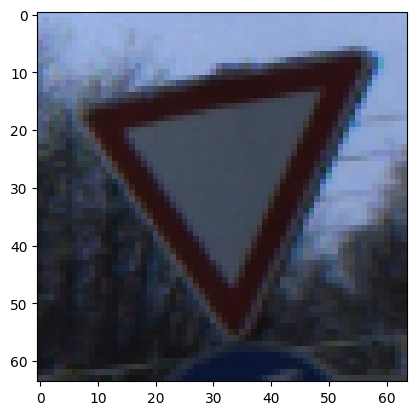

In [ ]:
plt.imshow(traffic_sign_dataset[10]['image'])

In [ ]:
idx = 1
sample = traffic_sign_dataset[idx]
print(f"Sample at index {idx}: {sample}")

Sample at index 1: {'image': array([[[0.3480689 , 0.29591854, 0.29331438],
        [0.35713178, 0.30582778, 0.30669233],
        [0.35536631, 0.30214652, 0.29926758],
        ...,
        [0.79233398, 0.81176088, 0.85174154],
        [0.60412646, 0.6550044 , 0.69418275],
        [0.51297871, 0.56365847, 0.60667318]],

       [[0.31743547, 0.25844535, 0.26282648],
        [0.31500172, 0.26180587, 0.269874  ],
        [0.3129452 , 0.26096239, 0.26776099],
        ...,
        [0.78978726, 0.81030561, 0.84759402],
        [0.6167873 , 0.66133483, 0.70029488],
        [0.51792662, 0.56613243, 0.60914714]],

       [[0.31884574, 0.25067593, 0.25472101],
        [0.30321404, 0.24747913, 0.25345339],
        [0.30305894, 0.25273629, 0.25840897],
        ...,
        [0.78757564, 0.81148897, 0.84576727],
        [0.62678271, 0.66301509, 0.70168218],
        [0.52432598, 0.56921147, 0.61596584]],

       ...,

       [[0.13171147, 0.13177179, 0.1282801 ],
        [0.14280025, 0.14546569, 0.1549

In [ ]:
# reshape(-1,1) ---> input 5000,1 || output ---> 5000,1
# 2, 4
# 3, 7
# ####
# 64 x 64 x 3 ---> 12288, 1 || output ---> 1,1
# ---> 1, 12288 || output ---> 1,1



In [ ]:
## image 64 x 64 x 3 ---> ## sign class

## 12288 rows --> 12288 rows of classes.

## 1 x 12288  --> 1 x 1

##
# volume --> occupancy

In [ ]:
print (sample['image'].shape)

(64, 64, 3)


In [ ]:
## add softmax
num_classes = 10
model = nn.Sequential(
        nn.Linear(12288, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
)

In [ ]:
bs = 16
dataloader = DataLoader(traffic_sign_dataset, batch_size=bs, shuffle=True, num_workers=4,drop_last=True)


In [ ]:
sample['image'].size()

# [[1,12288],[1,12288],[1,12288]...[1,12288]]
# [[1,1],[1,1],[1,1],,,,,[1,1]]


torch.Size([16, 64, 64, 3])

In [86]:
for i, sample in enumerate(dataloader):
  # print (sample['image'].size())
  sample = ts(sample)
  print (sample['image'].size(), sample['label'].size())
  # print (sample['label'])
  if i == 2:
    break

torch.Size([16, 12288]) torch.Size([16, 1])
torch.Size([16, 12288]) torch.Size([16, 1])
torch.Size([16, 12288]) torch.Size([16, 1])


In [77]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [78]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
ts = ToTensor()
n_epochs = 10
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader):
    optimizer.zero_grad()
    sample_batched = ts(sample_batched)
    outputs = model(sample_batched['image'])
    loss = criterion(outputs, sample_batched['label'])
    losses.append(loss.item())
    # print (loss)

    loss.backward()
    optimizer.step()
  mean_loss.append(np.mean(losses))
  print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')


 10%|█         | 1/10 [00:02<00:23,  2.58s/it]

Epoch 1/10, Training Loss: 0.6964


 20%|██        | 2/10 [00:05<00:20,  2.53s/it]

Epoch 2/10, Training Loss: 0.6990


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

Epoch 3/10, Training Loss: 0.7008


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

Epoch 4/10, Training Loss: 0.7031


 50%|█████     | 5/10 [00:13<00:13,  2.73s/it]

Epoch 5/10, Training Loss: 0.7034


 60%|██████    | 6/10 [00:16<00:10,  2.62s/it]

Epoch 6/10, Training Loss: 0.7031


 70%|███████   | 7/10 [00:18<00:07,  2.59s/it]

Epoch 7/10, Training Loss: 0.7029


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

Epoch 8/10, Training Loss: 0.7031


 90%|█████████ | 9/10 [00:25<00:02,  2.95s/it]

Epoch 9/10, Training Loss: 0.7023


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]

Epoch 10/10, Training Loss: 0.7025


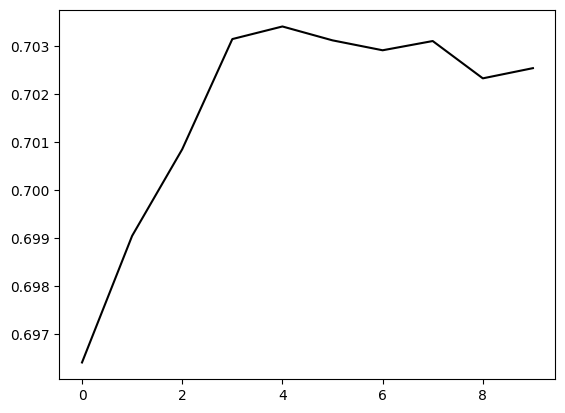

In [101]:
plt.plot(mean_loss,'k')

In [79]:
torch.save(model.state_dict(), 'traffic_model.pt')

In [ ]:
# ## load saved model
# model_arch = nn.Sequential(
#         nn.Linear(12288, 256),
#         nn.ReLU(),
#         nn.Linear(256, 128),
#         nn.ReLU(),
#         nn.Linear(128, 64),
#         nn.ReLU(),
#         nn.Linear(64, 1)
#         )
# model_arch.load_state_dict(torch.load('traffic_model.pt'))
# model_arch.eval()

In [80]:
num_classes = 10
model_arch = nn.Sequential(
        nn.Linear(12288, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
)
model_arch.load_state_dict(torch.load('traffic_model.pt'))
model_arch.eval()

Sequential(
  (0): Linear(in_features=12288, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): Softmax(dim=1)
)

In [102]:
ts = ToTensor()
for i_batch, sample_batched in enumerate(dataloader):
      sample_batched = ts(sample_batched)
      outputs = model(sample_batched['image'])
      output = outputs.reshape(-1).tolist()
      target = sample_batched['label'].reshape(-1).tolist()
      print (outputs.reshape(-1).tolist())
      print (sample_batched['label'].reshape(-1).tolist())
      print ('######')

[0.09946425259113312, 0.09940563142299652, 0.10024988651275635, 0.10127201676368713, 0.10115958750247955, 0.0995931550860405, 0.09985420852899551, 0.10035449266433716, 0.09943465888500214, 0.09921213239431381, 0.10033943504095078, 0.09834256023168564, 0.09856222569942474, 0.09962975978851318, 0.10180562734603882, 0.10126318037509918, 0.09872310608625412, 0.10160024464130402, 0.10110758244991302, 0.0986262857913971, 0.09937039017677307, 0.09811195731163025, 0.10160643607378006, 0.10160587728023529, 0.10433153063058853, 0.09714475274085999, 0.09865791350603104, 0.10096532106399536, 0.10084889084100723, 0.0973568856716156, 0.10003241151571274, 0.0987018495798111, 0.09864018857479095, 0.10032327473163605, 0.10228981822729111, 0.10157062113285065, 0.09853216260671616, 0.10137905925512314, 0.10006524622440338, 0.09846530109643936, 0.10027775913476944, 0.09865821897983551, 0.09855939447879791, 0.09990788996219635, 0.10100405663251877, 0.10177774727344513, 0.09912613779306412, 0.10148467123508

In [117]:
outputs = [0, 1, 0, 0]
targets = [0, 0, 1, 0]

# Compare the maximum values of each corresponding pair
results = [1 if max(o, t) == min(o, t) else 0 for o, t in zip(outputs, targets)]
print(results)

accuracy = np.mean(results)
print(accuracy)

[1, 0, 0, 1]
0.5


In [95]:
max_prob = max(output)
min_prob = min(output)

print(max_prob)
print(min_prob)

0.10527816414833069
0.0962226390838623


In [98]:
threshold = 0.099
output_binary = [1 if prob >= threshold else 0 for prob in output]

print(output_binary)

[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [103]:
np.argmax(output) == np.argmax(target)

False

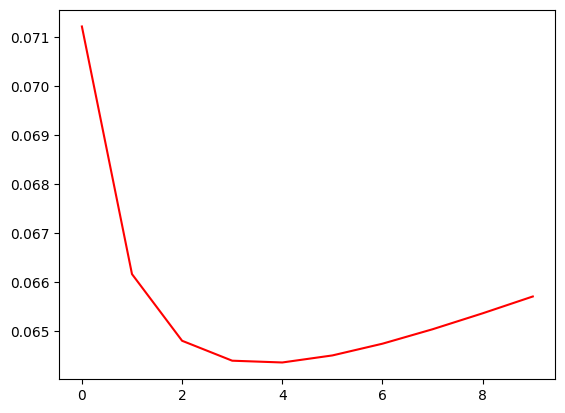

In [ ]:
# plt.plot(mean_loss,'k')
plt.plot(mean_test_loss,'r')

In [ ]:
## save a model
torch.save(model.state_dict(), 'model.pt')

In [ ]:
## load saved model
model_arch = my_first_nn(input_d,output_d)
model_arch.load_state_dict(torch.load('model.pt'))
model_arch.eval()

NameError: name 'input_d' is not defined

In [ ]:
bs = 5000
mu = traffic_obj_test.df['occupancy'].mean()
std = traffic_obj_test.df['occupancy'].mean()
dataloader = DataLoader(traffic_obj_test, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)
pred_obj = Predict(model_arch,mu,std)
pred_output = pred_obj(dataloader)

NameError: name 'traffic_obj_test' is not defined

In [ ]:
pred_output.keys()

dict_keys(['preds', 'targets', 'pred_denorm', 'target_denorm', 'mape'])

In [ ]:
pred_output['mape']

0.2302649193979098

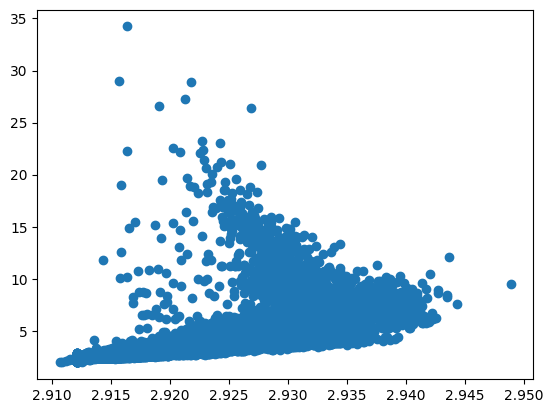

In [ ]:
plt.scatter(pred_output['pred_denorm'][0:30000],pred_output['target_denorm'][0:30000])

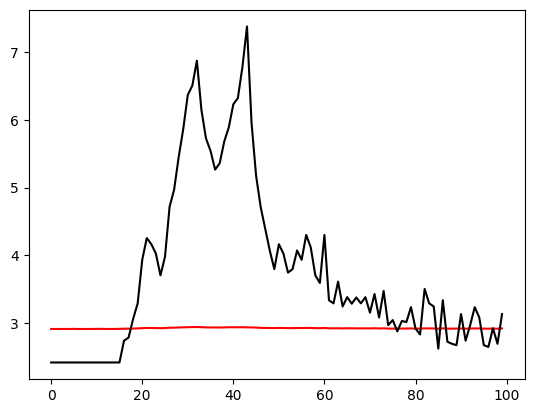

In [ ]:
plt.plot(pred_output['pred_denorm'][0:100],'r')
plt.plot(pred_output['target_denorm'][0:100],'k')